In [ ]:
import numpy as np
from scipy.signal import butter, filtfilt
import pickle

In [2]:
from matplotlib import font_manager
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

fontPath = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman_Italic.ttf'
fontProp = font_manager.FontProperties(fname = fontPath)

font_manager.fontManager.addfont(fontPath)
mpl.rcParams['font.family'] = fontProp.get_name()

In [3]:
numberChannels = 12
numberGestures = 10
trialsPerGesture = 36
numberSubjects = 91

In [4]:
collateData = []
Frequency = []

for subjectNumber in range(1, 100):
    if subjectNumber not in [5, 11, 14, 17, 18, 35, 38, 41]:
        name = "../formattedData/" + str(subjectNumber) + ".pkl"
        with open(name, "rb") as file:
            loadedData = pickle.load(file)

        Features = loadedData["EMG"]
        normalizedFeatures = Features
        Labels = loadedData["Labels"]
        samples = 2 * loadedData["Frequency"]

        Indices =  {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
        for i in range(len(Labels)):
            Indices[Labels[i]].append(i)

        gesturesLabels = np.zeros((numberGestures, trialsPerGesture, numberChannels, 4000))
        for i in range(numberGestures):
            for j in range(trialsPerGesture):
                gesturesLabels[i, j] = normalizedFeatures[Indices[i][j], :, :4000]
        
        collateData.append(gesturesLabels)
        Frequency.append(loadedData["Frequency"])

In [5]:
collateData = np.array(collateData)
Frequency = np.array(Frequency)

print(collateData.shape)
print(Frequency.shape)

(91, 10, 36, 12, 4000)
(91,)


In [6]:
def butterworthBandpass(lowcut, highcut, fs, order = 3):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype = 'band')
    return b, a

def applyBandpassFilter(data, lowcut, highcut, fs, order = 3):
    b, a = butterworthBandpass(lowcut, highcut, fs, order = order)
    filteredData = filtfilt(b, a, data, axis = -1)
    return filteredData

In [7]:
frequencies = np.array([[20, 50], [50, 110], [110, 230], [230, 450]])
print(frequencies)

[[ 20  50]
 [ 50 110]
 [110 230]
 [230 450]]


In [8]:
frequencies = np.array([[20, 50], [50, 110], [110, 230], [230, 450], [20, 450]])
filteredData = np.zeros((5, numberSubjects, numberGestures, trialsPerGesture, numberChannels, 4000))
for i in range(len(frequencies)):
    print(i)
    for subject in range(numberSubjects):
        filteredData[i, subject] = applyBandpassFilter(collateData[subject], frequencies[i, 0], frequencies[i, 1], Frequency[subject]) 

0
1
2
3
4


In [9]:
print(filteredData.shape)

(5, 91, 10, 36, 12, 4000)


In [10]:
powerData = np.zeros((numberGestures, 5, numberSubjects, 4000))

In [11]:
for gesture in range(numberGestures):

    gestureNumber = gesture
    oneGesture = filteredData[:, :, gestureNumber, :, :, :]
    power = np.zeros((5, numberSubjects, 4000))
    for i in range(5):
        power[i] = np.mean(np.square(oneGesture[i]), axis = (1, 2))

    powerData[gesture] = power

In [12]:
print(powerData.shape)

(10, 5, 91, 4000)


In [13]:
meanPowerData = np.mean(powerData, axis = 2)
print(meanPowerData.shape)

(10, 5, 4000)


In [14]:
cumsumMeanPower = np.cumsum(meanPowerData, axis = -1)
totalSum = np.sum(meanPowerData, axis = -1, keepdims = True)

resultArray = cumsumMeanPower/totalSum
print(cumsumMeanPower.shape)
print(totalSum.shape)
print(resultArray.shape)

(10, 5, 4000)
(10, 5, 1)
(10, 5, 4000)


In [15]:
timeEvolution = np.mean(meanPowerData, axis = 0)
cumsumMeanPowerEvolution = np.cumsum(timeEvolution, axis = -1)
totalSumEvolution = np.sum(timeEvolution, axis = -1, keepdims = True)

resultArrayEvolution = cumsumMeanPowerEvolution/totalSumEvolution
print(cumsumMeanPowerEvolution.shape)
print(totalSumEvolution.shape)
print(resultArrayEvolution.shape)

(5, 4000)
(5, 1)
(5, 4000)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


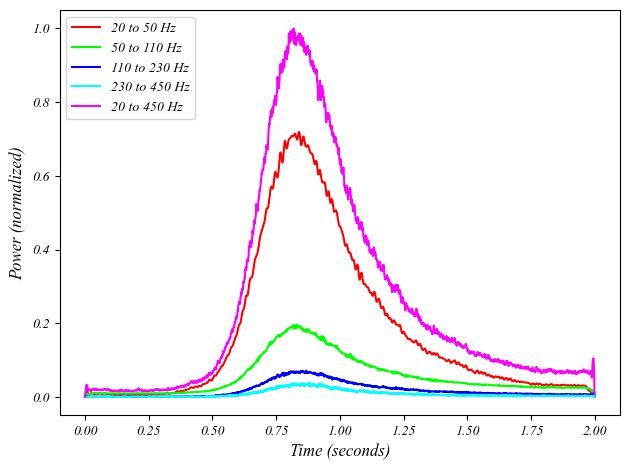

In [18]:
colors = ['#FF0000', '#00FF00', '#0000FF', '#00FFFF', '#FF00FF', '#FFA500', '#800080', '#A52A2A', '#FFC0CB']


plt.plot(list(np.arange(0, 2, 0.0005)), (timeEvolution[0] - np.min(timeEvolution))/(np.max(timeEvolution) - np.min(timeEvolution)), color = colors[0], label = "20 to 50 Hz")
plt.plot(list(np.arange(0, 2, 0.0005)), (timeEvolution[1] - np.min(timeEvolution))/(np.max(timeEvolution) - np.min(timeEvolution)), color = colors[1], label = "50 to 110 Hz")
plt.plot(list(np.arange(0, 2, 0.0005)), (timeEvolution[2] - np.min(timeEvolution))/(np.max(timeEvolution) - np.min(timeEvolution)), color = colors[2], label = "110 to 230 Hz")
plt.plot(list(np.arange(0, 2, 0.0005)), (timeEvolution[3] - np.min(timeEvolution))/(np.max(timeEvolution) - np.min(timeEvolution)), color = colors[3], label = "230 to 450 Hz")
plt.plot(list(np.arange(0, 2, 0.0005)), (timeEvolution[4] - np.min(timeEvolution))/(np.max(timeEvolution) - np.min(timeEvolution)), color = colors[4], label = "20 to 450 Hz")


plt.xlabel('Time (seconds)', fontproperties = fontProp, fontsize = 12)
plt.ylabel('Power (normalized)', fontproperties = fontProp, fontsize = 12)
    
plt.tight_layout()
plt.legend(loc = 'upper left')

plt.savefig("timeGesturesEvolution.eps", format = "eps", bbox_inches = 'tight')
plt.show()
plt.close()